In [45]:
import requests
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
from config import api_key

In [46]:
team_url = f'http://api.sportradar.us/nba/trial/v8/en/seasons/2022/REG/standings.json?api_key={api_key}'

team_data = requests.get(team_url).json()
def extract_team_data(data):
    teams = []
    if 'teams' in data:
        for team in data['teams']:
            team_id = team['id']
            team_name = team['name']
            teams.append({'id': team_id, 'name': team_name})
    if 'divisions' in data:
        for division in data['divisions']:
            teams += extract_team_data(division)
    if 'conferences' in data:
        for conference in data['conferences']:
            teams += extract_team_data(conference)
    return teams

# Extract team id and team name from the team_data dictionary
teams = extract_team_data(team_data)
teams_info=pd.DataFrame(teams)
teams_id= teams_info["id"]
time.sleep(1)


In [53]:
# Initialize
team_name=[]
team_field_goals=[]
team_id=[]
team_data={}
team_offensive_rebounds=[]
team_turnovers=[]
team_free_throws_att=[]
team_possession=[]
team_o_rtg=[]
team_d_rtg=[]
team_net_rtg=[]
field_goals_made=[]
three_points_made=[]
free_throws_made=[]
ow_defensive_rebounds=[]
opp_defensive_rebounds=[]
ow_points=[]
opp_points=[]
i=0
# Loop through each team ID and retrieve their statistics from the API
for i in range(len(teams_id)):
    team_url = f'http://api.sportradar.us/nba/trial/v8/en/seasons/2022/REG/teams/{teams_id[i]}/statistics.json?api_key={api_key}'
    team_data = requests.get(team_url).json()
    # Extract various statistics for the each team
    field_goals_att=team_data['own_record']['total']['field_goals_att']
    offensive_rebounds=team_data['own_record']['total']['offensive_rebounds']
    turnovers= team_data['own_record']['total']['turnovers']
    free_throws_att= team_data['own_record']['total']['free_throws_att']
    
    team_totals_dict = team_data['own_record']['total']
    opp_vs_team_totals_dict = team_data['opponents']['total']

    team_stat_keys = ['games_played', 'minutes', 'field_goals_made', 'field_goals_att',
                      'three_points_made', 'three_points_att', 'three_points_pct',
                      'free_throws_made', 'free_throws_att', 'offensive_rebounds',
                      'defensive_rebounds', 'rebounds', 'assists', 'turnovers',
                      'steals', 'blocks', 'points']
    team_stats = {k: v for k, v in team_totals_dict.items() if k in team_stat_keys}
    opp_vs_team_stats = {k: v for k, v in opp_vs_team_totals_dict.items() if k in team_stat_keys}

    #team stats calculations
    possession = 0.96*(field_goals_att + turnovers + (0.44*free_throws_att) -offensive_rebounds)
    o_rtg = 100 * (team_stats['points']) / (possession)
    d_rtg = 100 * (opp_vs_team_stats['points']) / (possession)
    net_rtg = (o_rtg) - (d_rtg)

    #Append the extracted statistics to teams' lists
    team_name.append(team_data['name'])
    team_id.append(team_data['id']) 
    team_field_goals.append(field_goals_att)
    field_goals_made.append(team_stats["field_goals_made"])
    team_offensive_rebounds.append(offensive_rebounds)
    team_turnovers.append(turnovers)
    team_free_throws_att.append(free_throws_att)
    team_possession.append(possession)
    team_o_rtg.append(o_rtg)
    team_d_rtg.append(d_rtg)
    team_net_rtg.append(net_rtg)
    three_points_made.append(team_stats["three_points_made"])
    free_throws_made.append(team_stats["free_throws_made"])
    ow_defensive_rebounds.append(team_stats["defensive_rebounds"])
    opp_defensive_rebounds.append(opp_vs_team_stats["defensive_rebounds"])
    ow_points.append(team_stats['points'])
    opp_points.append(opp_vs_team_stats['points'])


    # Pause execution for 0.5 second to avoid overloading the API
    time.sleep(1)  

# Create Teams DataFrame
teams_df=pd.DataFrame({
    'Team Name' : team_name,
    #'Team ID': team_id,
    'Team Possession': team_possession,
    'team_o_rtg': team_o_rtg,
    'team_d_rtg': team_d_rtg,
    'team_net_rtg': team_net_rtg ,
        
    'Team Field Goals Attempts':team_field_goals,
    'Team Field Goals Made':field_goals_made,
    'Team Offensive Rebounds': team_offensive_rebounds,
    'Team Defensive Rebounds': ow_defensive_rebounds,
    'Opp Defensive Rebounds': opp_defensive_rebounds,
    'Team Turnovers': team_turnovers,
    'Team Free throws Attemps': team_free_throws_att,
    'Team Free throws Made': free_throws_made,
    'Team Three Points Made':three_points_made,
    'Team Points': ow_points,
    'Opp Ponits': opp_points
   

})
teams_df

,Team Name,Team Possession,team_o_rtg,team_d_rtg,team_net_rtg,Team Field Goals Attempts,Team Field Goals Made,Team Offensive Rebounds,Team Defensive Rebounds,Opp Defensive Rebounds,Team Turnovers,Team Free throws Attemps,Team Free throws Made,Team Three Points Made,Team Points,Opp Ponits
0,Grizzlies,8143.4496,117.726522,113.760144,3.966378,7551,3585,988,2835,2738,1060,1954,1432,985,9587,9264
1,Pelicans,8009.2800,117.089177,115.153921,1.935255,7180,3447,866,2717,2634,1149,2000,1585,899,9378,9223
2,Mavericks,7820.2368,119.766194,119.689470,0.076724,6909,3283,625,2556,2838,957,2057,1554,1246,9366,9360
3,Rockets,8033.5872,113.037922,121.054266,-8.016344,7287,3329,1100,2695,2543,1267,2078,1567,856,9081,9725
4,Spurs,8257.1136,112.254723,122.221886,-9.967163,7593,3533,965,2619,2811,1208,1739,1292,911,9269,10092
5,Kings,8092.9920,122.303346,119.622014,2.681332,7232,3573,782,2699,2665,1076,2055,1624,1128,9898,9681
6,Suns,7925.4144,117.583757,115.438759,2.144998,7388,3453,971,2657,2676,1055,1781,1412,1001,9319,9149
7,Clippers,7900.1088,117.897110,117.378130,0.518980,7059,3370,803,2742,2699,1110,1962,1533,1041,9314,9273
8,Warriors,8202.4320,118.903759,117.099416,1.804343,7393,3538,864,2793,2673,1287,1655,1314,1363,9753,9605
9,Lakers,8202.3168,117.137636,116.564627,0.573009,7298,3516,818,2930,2770,1104,2182,1691,885,9608,9561


In [48]:
standing_url = f'http://api.sportradar.us/nba/trial/v8/en/seasons/2022/REG/standings.json?api_key={api_key}'
standing_data = requests.get(standing_url).json()
aa= standing_data["conferences"]
Teams_name=[]
standing_rank=[]
conferences2=[]
win=[]
n=i=j=0

for n in range(len(aa)):
    zz= standing_data["conferences"][n]['divisions']
    
    
    for i in range(len(zz)):
        bb=standing_data["conferences"][n]['divisions'][i]['teams']
        

        for j in range(len(bb)):
            Teams_name.append(standing_data["conferences"][n]['divisions'][i]['teams'][j]['name'])
            standing_rank.append(standing_data["conferences"][n]['divisions'][i]['teams'][j]['calc_rank']['conf_rank'])
            win.append(standing_data["conferences"][n]['divisions'][i]['teams'][j]['wins'])
            conferences2.append(standing_data["conferences"][n]['alias'])
    #b=pd.DataFrame[b]
    standing_df=pd.DataFrame({"Team Name": Teams_name,
                'Wins': win,
                'Conference Ranking': standing_rank,
                'Conferences':conferences2

   })
standing_df

,Team Name,Wins,Conference Ranking,Conferences
0,Grizzlies,51,2,WESTERN
1,Pelicans,42,10,WESTERN
2,Mavericks,38,11,WESTERN
3,Rockets,22,14,WESTERN
4,Spurs,22,15,WESTERN
5,Kings,48,3,WESTERN
6,Suns,45,4,WESTERN
7,Clippers,44,5,WESTERN
8,Warriors,44,6,WESTERN
9,Lakers,43,7,WESTERN


In [49]:
last_team_df=pd.merge(standing_df,teams_df,on="Team Name")
last_team_df=last_team_df.sort_values('Conference Ranking')
last_team_df

,Team Name,Wins,Conference Ranking,Conferences,Team Possession,team_o_rtg,team_d_rtg,team_net_rtg,Team Field Goals Attempts,Team Field Goals Made,Team Offensive Rebounds,Team Defensive Rebounds,Opp Defensive Rebounds,Team Turnovers,Team Free throws Attemps,Team Free throws Made,Team Three Points Made,Team Points,Opp Ponits
15,Bucks,58,1,EASTERN,8104.5888,118.315688,114.638759,3.676929,7411,3504,914,3074,2744,1137,1837,1364,1217,9589,9291
10,Nuggets,53,1,WESTERN,7872.9216,120.603259,117.135677,3.467582,7088,3574,828,2699,2516,1134,1834,1378,969,9495,9222
0,Grizzlies,51,2,WESTERN,8143.4496,117.726522,113.760144,3.966378,7551,3585,988,2835,2738,1060,1954,1432,985,9587,9264
25,Celtics,57,2,EASTERN,7971.2256,121.323878,114.612237,6.711640,7278,3460,796,2921,2810,1043,1769,1436,1315,9671,9136
26,76ers,54,3,EASTERN,7788.0192,121.314544,116.769101,4.545443,6870,3347,715,2641,2593,1052,2058,1719,1035,9448,9094
5,Kings,48,3,WESTERN,8092.9920,122.303346,119.622014,2.681332,7232,3573,782,2699,2665,1076,2055,1624,1128,9898,9681
6,Suns,45,4,WESTERN,7925.4144,117.583757,115.438759,2.144998,7388,3453,971,2657,2676,1055,1781,1412,1001,9319,9149
16,Cavaliers,51,4,EASTERN,7699.5456,119.552510,113.824899,5.727611,6984,3408,795,2574,2580,1020,1844,1439,950,9205,8764
27,Knicks,47,5,EASTERN,7875.1488,120.810416,117.762854,3.047561,7328,3444,1031,2790,2617,988,2087,1589,1037,9514,9274
7,Clippers,44,5,WESTERN,7900.1088,117.897110,117.378130,0.518980,7059,3370,803,2742,2699,1110,1962,1533,1041,9314,9273


The r-values is: 0.9557482676991007


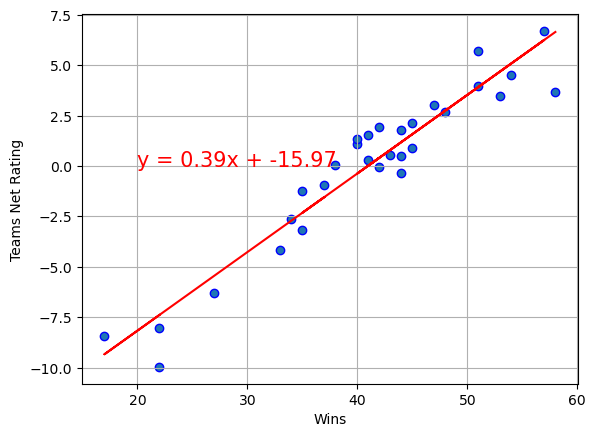

In [50]:
plt.scatter(last_team_df["Wins"], last_team_df["team_net_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("Wins")
plt.ylabel("Teams Net Rating")


#plt.ylim(-30, 50)

plt.grid(True)
x_values=last_team_df["Wins"]
y_values=last_team_df["team_net_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(20,0),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: 0.8218031162046007


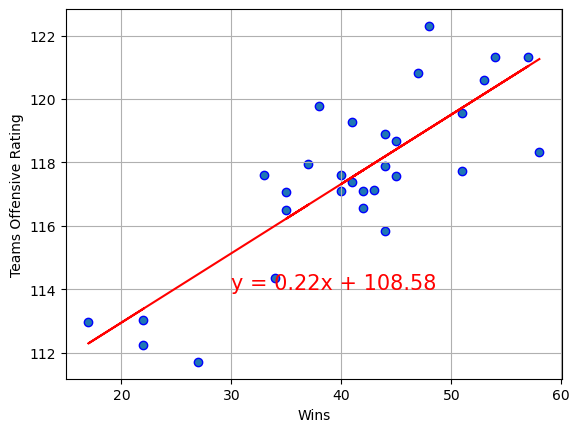

In [51]:
plt.scatter(last_team_df["Wins"], last_team_df["team_o_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("Wins")
plt.ylabel("Teams Offensive Rating")


#plt.ylim(-30, 50)

plt.grid(True)
x_values=last_team_df["Wins"]
y_values=last_team_df["team_o_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()

The r-values is: -0.7499353465723719


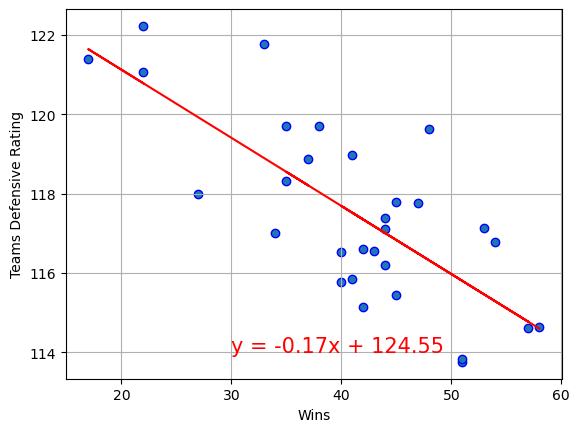

In [52]:
plt.scatter(last_team_df["Wins"], last_team_df["team_d_rtg"], edgecolor="Blue", alpha=1)

plt.xlabel("Wins")
plt.ylabel("Teams Defensive Rating")


#plt.ylim(-30, 50)

plt.grid(True)
x_values=last_team_df["Wins"]
y_values=last_team_df["team_d_rtg"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
r_values= x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,r_values,"r-")
plt.annotate(line_eq,(30,114),fontsize=15,color="red")
print("The r-values is: "+ str(rvalue))
plt.show()